In [175]:
%matplotlib inline
import os
import numpy as np
import random 
import matplotlib.pyplot as plt
from string import ascii_lowercase
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator

In [155]:
def random_file_name(size=5):
    return ''.join(random.sample(list(ascii_lowercase), size))

In [159]:
def create_test_folder(folder):
    if(not os.path.exists(folder)):
        print("Path doesnt exists")
        print(f"Creating: {folder}")
        os.mkdir(folder)
    print("Path already exists!!")
    
def create_test_files(folder, n=5):
    create_test_folder(folder)
    for _ in range(n):
        file = random_file_name()+".txt"
        
        try:
            print(f"creating file: {file}")
            file_path = os.path.join(folder, file)

            file = open(file_path, "a")
            file.close()
        
        except Exception as error:
            print(f"Failed creating {file}")

test_folder = os.path.join('.', 'files-test')
create_test_files(test_folder)

Path doesnt exists
Creating: ./files-test
Path already exists!!
creating file: xlupn.txt
creating file: zyedl.txt
creating file: vqzbd.txt
creating file: fovrj.txt
creating file: agbhl.txt


In [160]:
files = os.listdir(test_folder)
files

['xlupn.txt', 'zyedl.txt', 'vqzbd.txt', 'fovrj.txt', 'agbhl.txt']

In [163]:
def classical_method_1(files, target):
    #in this example, we are ignoring the extension
    #just for this case, in real life a good idea is to use the entire name, or a hash of it

    #unsing no type of lookup table, or sorting, the algorithm takes O(n)
    total_tests = 0
    for file in files:
        total_tests += 1
        print(f"total tests: {total_tests}")
        if(file.replace('.txt', '') == target):
            print("found file")
            break

classical_method_1(files, "vqzbd")

total tests: 1
total tests: 2
total tests: 3
found file


In [164]:
def classical_method_2(files, target):

    # this should be done after adding a file into the filesystem
    # it takes O(1) for adding a new file, O(n) for adding n files and O(1) for searching
    lut = {}
    for file in files:
        file_hash = hash(file.replace('.txt', ''))
        lut[file_hash] = file

    target_hash = hash(target)
    if lut.get(target_hash):
        print("File found")
    else:
        print("File doesnt exists in the filesystem")
        
classical_method_2(files, 'vqzbd')

File found


---

In [165]:
n_qubits = int(np.ceil(np.log2(len(files))))

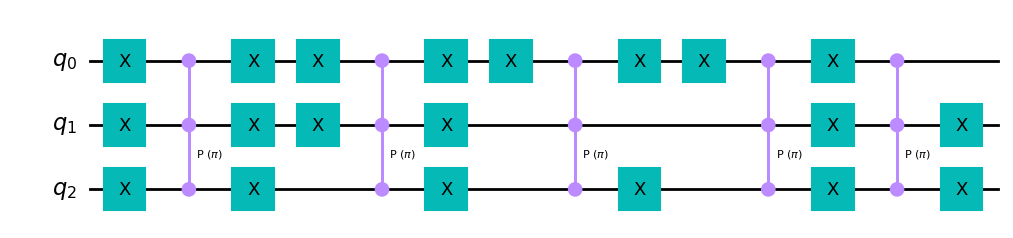

In [166]:
def encoding_files_to_oracle(n_qubits, files):
    oracle = QuantumCircuit(n_qubits, name="LUT")

    encoded_bin = [bin(i)[2:].zfill(n_qubits) for i in range(len(files))]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

binary,oracle = encoding_files_to_oracle(n_qubits,files)
oracle.draw('mpl')

In [181]:
def get_oracle_overload(files, targets):
    oracle = QuantumCircuit(n_qubits, name="$LUT^{-1}$")

    encode = lambda x,n: bin(x)[2:].zfill(n)
    encoded_bin = [encode(i,n_qubits) for i, file in enumerate(files) if file not in targets]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

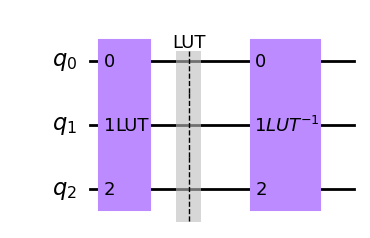

In [188]:
lut_binary,oracle = encoding_files_to_oracle(n_qubits,files)
unvalid_states,oracle_inv = get_oracle_overload(files, ['vqzbd.txt'])

good_state = list(set(lut_binary) - set(unvalid_states))

n_qubits = len(oracle.qubits)

qc = QuantumCircuit(n_qubits)
qc.append(oracle, range(n_qubits))
qc.barrier(label="LUT")
qc.append(oracle_inv, range(n_qubits))
qc.draw('mpl')

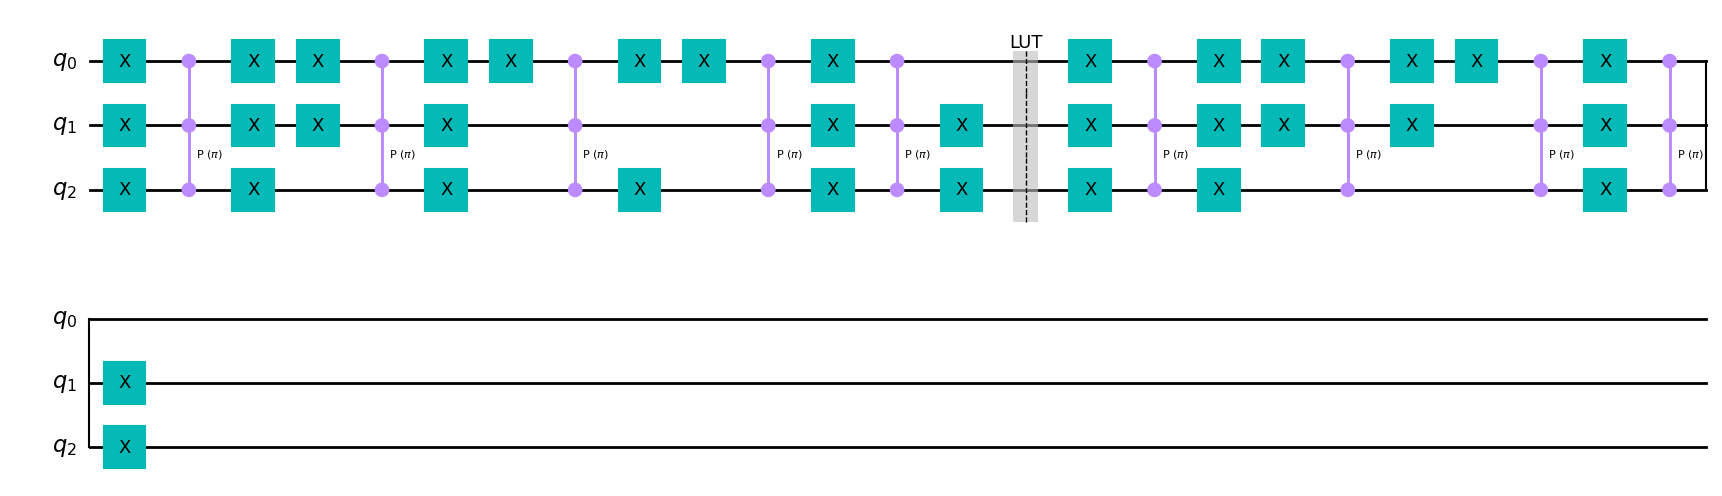

In [171]:
qc.decompose().draw('mpl')

In [172]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

In [183]:
qc_copy = qc.copy()
qc_copy.save_unitary()

sim = AerSimulator()
unitary = sim.run(transpile(qc_copy, sim)).result().get_unitary()
array_to_latex(unitary, max_size=10000)

<IPython.core.display.Latex object>

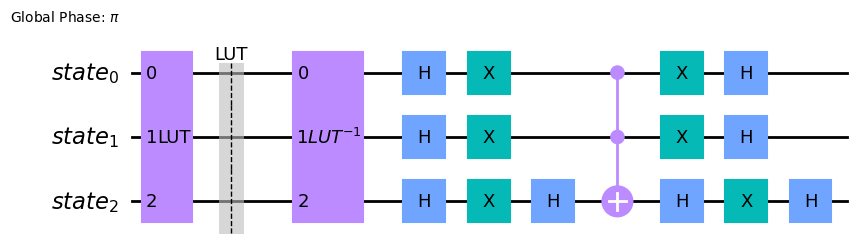

In [190]:
problem = AmplificationProblem(qc, is_good_state=good_state)
problem.grover_operator.decompose().draw(output='mpl')

In [193]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
result.top_measurement

'010'